In [ ]:
from dotenv import load_dotenv
import os

# Load environment variables from .env in project root
load_dotenv()

googleAPIKey = os.getenv('googleAPIKey')
gptkey = os.getenv('myAPIKey')


In [ ]:
!pip install -q --force transformers==4.52.4
!pip install -U bitsandbytes
!pip install -q --force accelerate==1.7.0
!pip install -q --force langchain==0.3.25
!pip install -q --force langchainhub==0.1.21
!pip install -q --force langchain-chroma==0.2.4
!pip install -q --force langchain_experimental==0.3.4
!pip install -q --force langchain-community==0.3.24
!pip install -q --force langchain_huggingface==0.2.0
!pip install -q --force python-dotenv==1.1.0
!pip install -q --force pypdf
!pip install langchain_openai
!pip install langchain-google-genai


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.3.4 which is incompatible.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.10.0 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.4 which is incompatible.
s3fs 2024.6.1 requires fsspec==2024.6.1.*, but you have fsspec 2025.10.0 which is incompatible.
scipy 1.13.1 requires numpy<2.3,>=1.22.4, but you have numpy 2.3.4 which is incompatible.
streamlit 1.37.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependenc

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
     ------------------ --------------------- 1.8/4.0 MB 12.6 MB/s eta 0:00:01
     ---------------------------------------- 4.0/4.0 MB 10.9 MB/s  0:00:00
     ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
     --------------- ------------------------ 1.6/4.0 MB 12.0 MB/s eta 0:00:01
     ---------------------------------------  3.9/4.0 MB 11.2 MB/s eta 0:00:01
     ---------------------------------------- 4.0/4.0 MB 10.9 MB/s  0:00:00
     ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
     ------- -------------------------------- 0.8/4.0 MB 6.7 MB/s eta 0:00:01
     ---------------------------- ----------- 2.9/4.0 MB 8.8 MB/s eta 0:00:01
     -------------------------------

  You can safely remove it manually.
  You can safely remove it manually.


In [ ]:
!pip install sentence-transformers==2.2.2 
!pip install accelerate


In [30]:
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain_huggingface import HuggingFacePipeline
from langchain import hub

from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import OpenAIEmbeddings
import re

import torch
import json
import glob


c:\Users\ADMIN\anaconda3\envs\Phuc1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load file

In [ ]:
metadata_dir = "C:\\uit_HK5\\CS431\\final_project\\data\\metadata.json"
transcript_dir = "C:\\uit_HK5\\CS431\\final_project\\data\\transcripts"
output_dir = "C:\\uit_HK5\\CS431\\final_project\\data\\semantic_chunks"
os.makedirs(output_dir, exist_ok=True)


In [ ]:
class Loader:
    @staticmethod
    def parse_transcript(file_path: str) -> tuple[str, list[dict], str]:
        """Đọc file transcript, tách từng dòng thành block có start-end-text"""
        full_text = ""
        position_map = []  # lưu vị trí start của mỗi đoạn text trong full_text

        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line or "[âm nhạc]" in line.lower():
                    continue
                filename = os.path.basename(file_path).replace(".txt", "") # lấy file name
                match = re.match(r"(\d+:\d+:\d+)\s*-\s*(\d+:\d+:\d+),\s*(.+)", line)
                if match:
                    start, end, text = match.groups()
                    pos = len(full_text)
                    full_text += text + " "
                    position_map.append({
                        "start": start,
                        "end": end,
                        "text": text,
                        "pos_start": pos, # vị trí bắt đầu của đoạn text trong full_text
                        "pos_end": len(full_text) # vị trí kết thúc của đoạn text trong full_text
                    })

        return full_text.strip(), position_map, filename
    
    def map_metadata(self, metadata_path: str, filename: str) -> tuple[str | None, str | None]:
        """Đọc file metadata và trả về dict mapping id -> metadata"""

        with open(metadata_path, "r", encoding="utf-8") as f:
            metadata_list = json.load(f)
        metadata = metadata_list["videos"]

        video_title, video_url = next(((item["title"], item["url"]) for item in metadata if item["video_id"] == filename), (None, None))

        return video_title, video_url
    
    def load_dir(self, transcript_dir: str, metadata_path: str) -> list[dict]:
        """Đọc tất cả file transcript trong thư mục và trả về danh sách dict chứa full_text, position_map, filename, title, url"""
        import glob

        file_paths = glob.glob(os.path.join(transcript_dir, "*.txt"))
        data = []

        for file_path in file_paths:
            full_text, position_map, filename = self.parse_transcript(file_path)
            title, url = self.map_metadata(metadata_path, filename)

            data.append({
                "full_text": full_text,
                "position_map": position_map,
                "filename": filename,
                "title": title,
                "url": url
            })

        return data
        

In [37]:
loader = Loader()
data = loader.load_dir(transcript_dir, metadata_dir)
print(data)

[{'full_text': 'Như vậy thì trong phần số 2 này thì chúng ta đã cùng tìm hiểu về những chủ đề sau. Đầu tiên là chúng ta tìm hiểu về maximum likelihood cho cái log của PX. Chúng ta mong muốn có được một mô hình để tạo ra một cái ảnh x giống thật, giống với lại cái Pdata. Thế thì để đạt được cái việc này thì cái likelihood của log P này phải là lớn nhất. Và khi đưa cái log của PX này lên cực đại thì nó sẽ đưa đến một cái giải pháp, đó là chúng ta sẽ đẩy cái chặn dưới của log P. Thì đó chính là cái ELBO là evidence lower bound. Đẩy cái ELBO này lên, maximum ELBO này lên. Và khi chúng ta maximum ELBO này lên thì chúng ta sẽ có hai cái mô hình, đó là VAR và mô hình diffusion. Và đối với cái mô hình diffusion thì chúng ta sẽ có cái bước gọi là khuếch tán thuận. Và trong cái khuếch tán thuận này thì chúng ta sẽ thêm nhiễu vào cái ảnh của mình. Và ở đây là chúng ta không có tham số để học, không có tham số huấn luyện. Cái điều này nó giúp cho chúng ta đơn giản hóa cái việc huấn luyện của cái m

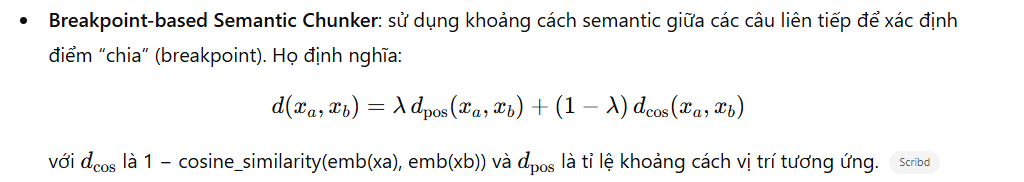

In [79]:

from pyparsing import line


class TranscriptChunker:
    def __init__(self, open_api_key: str):
        self.embeddings = OpenAIEmbeddings(
            model="text-embedding-3-large",
            openai_api_key=open_api_key
        )
        self.splitter = SemanticChunker(
            embeddings=self.embeddings,
            breakpoint_threshold_type="percentile",
            breakpoint_threshold_amount=85,
            min_chunk_size=300,

            add_start_index=True,
            buffer_size=1
        )
        self.loader = Loader()

    def chunk_dir(self, transcript_dir: str, metadata_path: str, output_dir: str) -> list:
        data = self.loader.load_dir(transcript_dir, metadata_path)
        all_chunks = []

        for item in data:
            full_text = item["full_text"]
            position_map = item["position_map"]
            filename = item["filename"]
            title = item["title"]
            url = item["url"]

            # dùng lại logic mapping timestamp
            chunks = self.splitter.create_documents(
                texts=[full_text],
                metadatas=[{
                    "video_url": url,
                    "filename": filename,
                    "title": title
                }]
            )
            for i, chunk in enumerate(chunks):
                start_index = chunk.metadata.pop("start_index")
                end_index = start_index + len(chunk.page_content)  # tự tính end_index

                
                # tìm timestamp đầu tiên bao phủ đoạn text này
                matched_ts = [
                    pos for pos in position_map
                    if not (pos["pos_end"] < start_index or pos["pos_start"] > end_index)
                ]

                if matched_ts:
                    chunk.metadata["start_timestamp"] = matched_ts[0]["start"]
                    chunk.metadata["end_timestamp"] = matched_ts[-1]["end"]
                else:
                    chunk.metadata["start_timestamp"] = None
                    chunk.metadata["end_timestamp"] = None

                chunk.metadata["chunk_id"] = i
            all_chunks.extend(chunks)
        # lưu tất cả chunks vào file json
        output_path = os.path.join(output_dir, "semantic_chunks.json")
        with open(output_path, "w", encoding="utf-8") as f:
            json.dump([{
                "page_content": chunk.page_content,
                "metadata": chunk.metadata
            } for chunk in all_chunks], f, ensure_ascii=False, indent=4)
        print(f"Saved {len(all_chunks)} chunks to {output_path}")
        return all_chunks


In [113]:
splitter = TranscriptChunker(
    open_api_key= gptkey
)
data = splitter.chunk_dir("C:\\uit_HK5\\CS431\\final_project\\data\\test", metadata_dir, output_dir)

Saved 18 chunks to C:\uit_HK5\CS431\final_project\data\semantic_chunks\semantic_chunks.json


In [114]:
for chunk in data:
    print(chunk.page_content)
    print(chunk.metadata["start_timestamp"], chunk.metadata["end_timestamp"])
    print(chunk.metadata["video_url"])
    print(chunk.metadata["title"])
    print("-----")

Lan truyền ngược là một trong những thuật toán rất phổ biến trong các mô hình học dựa trên Gradient Và trong đó có rất nhiều mô hình hiện đại như Deep Learning, học sâu Chi tiết thuật toán Backpropagation vận hành như thế nào, chúng ta sẽ cùng tìm hiểu trong những chương sau Đầu tiên chúng ta sẽ nhắc lại về mô hình dựa trên Gradient Trong mô hình dựa trên Gradient, chúng ta phải tính toán giá trị y đoán là y ngã Y ngã trong trường hợp này chính là bằng fθx Và mình mong muốn là cho giá trị dự đoán xấp xỉ với giá trị thực tế Thế thì có 3 công việc cần phải làm, chúng ta đang tập trung vào công việc cuối cùng Đối với công việc tìm tham số tối ưu của mô hình, tức là tìm theta sao cho hàm lỗi này là nhỏ nhất Trong hồi trước chúng ta đã nói có một số thuật toán để tìm gradient tối ưu Cụ thể đó là Stochastic Gradient Descent, Momentum, Root Mean Square Propagation và Adam Thế thì chúng ta sẽ cùng ôn lại các thuật toán này, thì nó sẽ có những điểm đặc điểm gì chung Chúng ta thấy là cả 3 thuật 

In [115]:
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

model_name = "BAAI/bge-m3"            # đa ngôn ngữ, gọn nhẹ, khuyên dùng

embedding = HuggingFaceEmbeddings(model_name=model_name,model_kwargs={"device": "cuda"})

## lưu vào db

vector_db = Chroma.from_documents(documents=data , embedding= embedding, persist_directory="./chroma_trans")
retriever = vector_db.as_retriever(search_type="similarity", search_kwargs={"k": 5})

In [88]:
result = retriever.invoke("Backpropagation chi tiết")

print(result[0].metadata)

{'chunk_id': 0, 'title': '[CS315 - Chương 1] Mô hình học máy dựa trên Gradient (Phần 8)', 'end_timestamp': '0:07:55', 'video_url': 'https://youtube.com/watch?v=0PqzYo2Z-20', 'start_timestamp': '0:00:13', 'filename': '0PqzYo2Z-20'}


In [116]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import numpy as np

# 🔹 Lấy toàn bộ embedding và metadata từ Chroma
# (nếu bạn đã load vector_db = Chroma.from_documents(...) như trên)
data = vector_db.get()  

vectors = vector_db.get(include=["embeddings"])
vectors = np.array(vectors["embeddings"])
documents = data["documents"]
metadatas = data["metadatas"]

# 🔹 Nếu bạn có nhiều loại document, có thể trích ra từ metadata
doc_types = [m.get("title", "unknown") for m in metadatas]
colors = ["blue" if t == "unknown" else "red" for t in doc_types]

# 🔹 Giảm số chiều xuống 2D để trực quan hóa
tsne = TSNE(n_components=2, random_state=42, perplexity=1)
reduced_vectors = tsne.fit_transform(vectors)

# 🔹 Vẽ biểu đồ scatter 2D
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=6, color=colors, opacity=0.8),
    text=[
        f"<b>Loại:</b> {t}<br><b>Văn bản:</b> {d[:200]}..." 
        for t, d in zip(doc_types, documents)
    ],
    hoverinfo='text'
)])

fig.update_layout(
    title='📊 Phân bố embedding trong Chroma Vector Store (2D)',
    xaxis_title='TSNE Dimension 1',
    yaxis_title='TSNE Dimension 2',
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40),
)

# 🔹 Hiển thị trực tiếp trên browser
fig.show(renderer="browser")


## Reranking by BM25 + create hybrid search with semantic search + bm25

## prompt

In [63]:
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

model_name = "BAAI/bge-m3"            # đa ngôn ngữ, gọn nhẹ, khuyên dùng

embedding = HuggingFaceEmbeddings(model_name=model_name,model_kwargs={"device": "cuda"})

## lưu vào db
vector_db = Chroma( embedding_function= embedding, persist_directory="./chroma_txt")
retriever = vector_db.as_retriever(search_type="similarity", search_kwargs={"k": 5})

In [89]:


nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True
)

MODEL_NAME = "Qwen/Qwen3-0.6B"


model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    dtype=torch.float16,   # dùng float16 cho GPU
    #device_map="auto"      # tự động đặt model lên GPU
)
model.to("cuda")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True,trust_remote_code=True)



In [119]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",   # hoặc gemini-1.5-pro, gemini-2.0-flash
    temperature=0.0,
    google_api_key=googleAPIKey  # 👈 thêm dòng này
)

In [90]:
model_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id,
    device=0  # chạy trên CPU

)

llm = HuggingFacePipeline(pipeline=model_pipeline)


Device set to use cuda:0


In [120]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableMap,RunnableLambda


class VideoAnswer(BaseModel):
    text: str = Field(description="Câu trả lời tóm tắt trong 3 câu")
    filename: str = Field(description="Tên file transcript gốc")
    video_url: str = Field(description="URL của video gốc")
    start_timestamp: str = Field(description="Thời điểm bắt đầu (format: HH:MM:SS)")
    confidence: str = Field(description="Độ tin cậy: zero/low/medium/high")

parser = JsonOutputParser(pydantic_object=VideoAnswer)

# ===== Prompt =====
prompt = ChatPromptTemplate.from_template("""
Dựa vào transcript sau, trả lời câu hỏi của người dùng bằng tiếng Việt.Phần tóm tắt nội dung thì nên tóm tắt trong 3 câu, 
dựa vào các đoạn transcript được cung cấp và chỉ ra đoạn video chứa thông tin đó (video url, thời điểm bắt đầu và kết thúc).
Đồng thời làm mượt lại nội dung tóm tắt đó
Nếu không biết câu trả lời thì cứ trả lời là tôi không biết và độ tin cậy là zero
Nếu câu hỏi không liên quan đến nội dung video thì trả lời tôi chỉ được huấn luyện trả lời các câu hỏi liên quan đến nội dung video và độ tin cậy là zero
Không bịa ra thông tin không có căn cứ, không trả lời sai format
Nếu bạn cực kỳ chắc chắn về câu trả lời, hãy đặt độ tin cậy là high. Nếu bạn khá chắc chắn, hãy đặt độ tin cậy là medium. Nếu bạn không chắc chắn về câu trả lời, hãy đặt độ tin cậy là low.
Định dạng đầu ra phải tuân theo JSON schema sau:
{format_instructions}
Transcript:
{context}

Câu hỏi: {question}
\nAnswer:                                          
""")

def format_doc(docs):
    return "\n\n".join(f"""
[Video URL]: {doc.metadata.get('video_url')}
[Filename]: {doc.metadata.get('filename')}
[Start]: {doc.metadata.get('start_timestamp')}
[Content]: {doc.page_content}
confidence: Optional[str] = Field(default="medium", description="Độ tin cậy: low/medium/high")
""" for doc in docs)

def extract_json_from_output(output: str) -> str:
    return output.split('Answer')[1].strip()
    
# ===== Tạo RAG chain =====
rag_chain = (
    {
        "context": retriever | format_doc,  # format từng doc
        "question": RunnablePassthrough()
    }
    | prompt.partial(format_instructions=parser.get_format_instructions())
    | llm 
    #| #extract_json_from_output # lấy phần đằng sau answer ( là định dạng json đã chuẩn bị)
    #RunnableLambda(lambda x: extract_json_from_output(x))
    #|parser
)

C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3550: LangChainDeprecationWarning:

As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel




In [122]:
import time
start = time.time()
result = rag_chain.invoke("Backpropagation chi tiết")
print(result.content)
end = time.time()
print("Thời gian:", end - start)


```json
{
  "text": "Backpropagation (lan truyền ngược) là một thuật toán phổ biến trong các mô hình học dựa trên Gradient, đặc biệt là trong học sâu. Tuy nhiên, transcript này chỉ giới thiệu về Backpropagation và nêu rõ rằng chi tiết về cách thuật toán này vận hành sẽ được tìm hiểu trong các chương sau. Thay vào đó, nội dung tập trung vào các khái niệm nền tảng như việc tính toán Gradient, những khó khăn khi tính đạo hàm cho các hàm lỗi phức tạp và đa biến, cũng như giới thiệu quy tắc chuỗi (chain rule) và thuật toán lan truyền thuận (Feed Forward) như những công cụ cần thiết để chuẩn bị cho việc hiểu Backpropagation.",
  "filename": "0PqzYo2Z-20",
  "video_url": "https://youtube.com/watch?v=0PqzYo2Z-20",
  "start_timestamp": "00:00:13",
  "confidence": "high"
}
```
Thời gian: 9.370862483978271


In [49]:
# ===== Gọi truy vấn =====
query = "transformer là gì"
result = rag_chain.invoke(query)

print(result)

{'text': 'Transformer là một trong những thành tựu nổi bật của deep learning, được phát triển dựa trên các kiến trúc truyền thống như RNN và Transformer. Nó sử dụng các kỹ thuật như skip connection, layer norm, và các optimizer như Adam để tối ưu hóa quá trình huấn luyện.', 'filename': '[CS315 _ Chương 0] Giới thiệu môn học (Phần 3) _ YouTube', 'video_url': 'https://www.youtube.com/watch?v=Vm18bFk-RsI&list=PLb62OySGqC9xHEhxcX1BIX2H8oyvwOzCP', 'start_timestamp': '0:00:13', 'end_timestamp': '0:00:13'}
